In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [2]:
class HopfieldNetwork:
    def __init__(self, n, states, weights):
        self.n = n
        self.bias = np.random.uniform(-1,1, n)
        self.states = states
        self.weights = weights
    def Energy(self):
        energy = np.outer(self.states, self.states) * self.weights
        energy = np.sum(energy) - np.trace(energy)
        energy = -0.5 * energy
        energy += np.sum(self.bias * self.states)
        return energy
    def StepOnOne(self, ind = -1):
        n = self.n
        if ind == -1:
            ind = np.random.randint(0,n)
        Tea = self.weights[ind,:] @ self.states - self.weights[ind,ind]*self.states[ind]
        if Tea > self.bias[ind]:
            self.states[ind] = 1
        else:
            self.states[ind] = -1
    def CheckConvergence(self):
        n = self.n
        for ind in range(n):
            if self.CheckIfUpdate(ind):
                return False
        return True
    def CheckIfUpdate(self,ind):
        T = self.weights[ind,:] @ self.states
        if T > self.bias[ind]:
            if self.states[ind] != 1:
                return True
        else:
            if self.states[ind] != -1:
                return True
        return False
    def Train(self):
        for i in range(10000):
            self.StepOnOne()
            if i > 200 and i % 100==0:
                if self.CheckConvergence():
                    break



See energy goes down

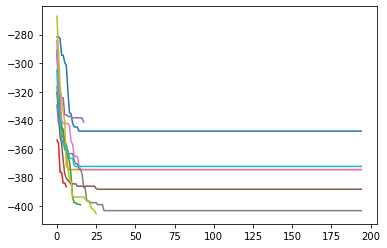

In [3]:
n = 100
for iter in range(10):

    #---------------generate weight------
    states = np.random.choice([-1,1],n)
    weights = np.random.uniform(-1,1, (n,n))
    for a in range(n):
        for b in range(a,n,1):
            weights[a,b] = weights[b,a]
    #---------------generate weight-------

    hopfieldNetwork = HopfieldNetwork(n, states,weights)
    energyOverUpdate = []
    for i in range(10000):
        hopfieldNetwork.StepOnOne()
        if i > 200 and i%50==0:
            energyOverUpdate.append(hopfieldNetwork.Energy())
            if hopfieldNetwork.CheckConvergence():
                break
    plt.plot(energyOverUpdate)

In [4]:
def HammingDist(a,b):
    a = a.copy().flatten()
    b = b.copy().flatten()
    return np.sum(np.abs(a-b)) * 0.5

Feed some samples

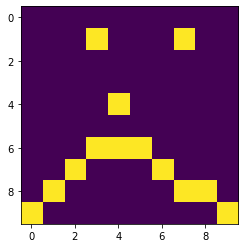

In [5]:
smileFace = np.array(list('0000000000000100010000000000000000000000000010000000000000000001110000001000100001000001101000000001'), dtype=int).reshape(-1,1) * 2 -1
tree = np.array(list('0001111000000111100000001100000000110000001111111000001100100000110000000011000000001100000000110000'),dtype=int).reshape(-1,1) * 2 -1
samples = np.concatenate([smileFace, tree], axis=1)
n = samples.shape[0]
m = samples.shape[1]
weights = 1/m * samples @ samples.T
states = np.random.choice([-1,1],n)
hopfieldNetwork = HopfieldNetwork(n, states, weights)
plt.imshow(smileFace.reshape((10,10)))

Purturb a sample

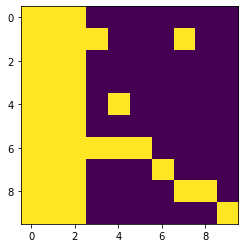

In [6]:
smileFaceErased = samples[:,0].copy()
smileFaceErased = smileFaceErased.reshape((10,10))
smileFaceErased[:,:3]=1
smileFaceErased = smileFaceErased.reshape(-1,1)
plt.imshow(smileFaceErased.reshape((10,10)))

Recover

0.0


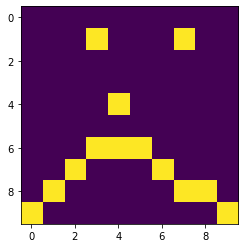

In [7]:
hopfieldNetwork.states = smileFaceErased.copy()
hopfieldNetwork.Train()
"""for i in range(500):
    hopfieldNetwork.StepOnOne()
    if hopfieldNetwork.CheckConvergence():
        print('convergence after ', i)
        break"""
result = hopfieldNetwork.states.copy()
print(HammingDist(result, smileFace))
plt.imshow(result.reshape(10,10))


Test how many samples can the network remember

In [8]:
pMax = 100 #number of samples
kMax = 100 #number of bits to flip
cMax = 5 #number of samples to calculate average distance
n = 100
allIndices = np.arange(n)
pkMat = np.zeros((kMax,pMax))

for p in range(1, pMax+1, 1):

    samples = np.random.choice([-1,1],(n,p))
    weights = 1/p * samples @ samples.T
    hopfieldNetwork = HopfieldNetwork(n, samples[:,0].copy(), weights)
    #-----------generate a network trained on p samples------------

    for k in range(kMax):
        #pick k number of bits to flip

        avgDist = 0
        for c in range(cMax):
            testSampleInd = np.random.randint(0,p)
            testSample = samples[:,testSampleInd].flatten().copy()
            hopfieldNetwork.states = testSample.copy()
            #---------pick a random sample------
            np.random.shuffle(allIndices)
            randIndices = allIndices[:k] #pick k indices
            testSample[randIndices] *= -1
            #---------flip on random indices----
            
            hopfieldNetwork.Train()
            avgDist += HammingDist(hopfieldNetwork.states, testSample) / cMax
        pkMat[k,p-1] = avgDist


Text(0, 0.5, 'fraction of corrupted bits')

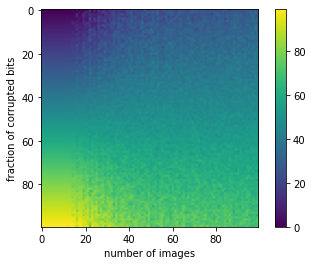

In [9]:
plt.imshow(pkMat)
plt.colorbar()
plt.xlabel('number of images')
plt.ylabel('fraction of corrupted bits')

In [10]:
n = 7
m = 2
ref = np.zeros(n,dtype=int)
for i in range(n):
    ref[i] = 2**(n-1-i)
def States2Int(states, ref):
    #1->1, 0->-1
    states = states.flatten()
    states01 = states / 2 + 0.5
    return int(np.sum(states01 * ref))
def Int2States(i, n):
    statesBin = list(bin(i)[2:])
    states = np.zeros(n, dtype=int)
    states[-len(statesBin):] = statesBin
    states = states * 2 - 1
    return states
samples = np.zeros((n,m))
samples[:,0] = Int2States(28, n)
samples[:,1]  = Int2States(35, n)
weights = 1/m * samples @ samples.T

statesIntEmissionMap = {}

for statesAsInt in range(2**n):
    states = Int2States(statesAsInt, n)
    hopfieldNetwork = HopfieldNetwork(n, states, weights)
    statesIntEmissionMap[statesAsInt] = []
    for ind in range(n):
        #check every node
        if hopfieldNetwork.CheckIfUpdate(ind):
            targetStates = states.copy()
            targetStates[ind] *= -1
            targetStatesAsInt = States2Int(targetStates, ref)
            statesIntEmissionMap[statesAsInt].append(targetStatesAsInt)

generate graph of state flow

In [13]:
dot = graphviz.Digraph()
for initState in statesIntEmissionMap.keys():
    dot.node(str(initState))
    for targetState in statesIntEmissionMap[initState]:
        dot.edge(str(initState),str(targetState))
dot.view()

'Digraph.gv.pdf'

generate plot of state emission

In [14]:
for initState in statesIntEmissionMap.keys():
    plt.scatter()
    for targetState in statesIntEmissionMap[initState]:
        dot.edge(str(initState),str(targetState))

[47]

Restricted Boltzmann Machine

In [11]:
class RBM:
    def __init__(self, nHidden, nVisible):
        self.nVisible = nVisible
        self.nHidden = nHidden
        self.statesVisible = np.random.choice([-1.0,1], (1, nVisible))
        self.statesHidden = np.random.choice([-1.0,1], (nHidden,1))
        self.weights = 2 * (np.random.rand(nVisible, nHidden) -0.5)
        self.biasHidden = 2 * (np.random.rand(nHidden)-0.5).reshape(1,-1)
        self.biasVisible = 2 * (np.random.rand(nVisible)-0.5).reshape(-1,1)
    def RandomizeStates(self):
        self.statesVisible = np.random.choice([-1.0,1], (1, self.nVisible))
        self.statesHidden = np.random.choice([-1.0,1], (self.nHidden,1))
    def Energy(self):
        energyVisible = (self.statesVisible @ self.biasVisible).flatten()[0]
        energyHidden = (self.biasHidden @ self.statesHidden).flatten()[0]
        energyCross = (self.statesVisible@(self.weights@self.statesHidden)).flatten()[0]
        energy = -energyVisible - energyHidden - energyCross
        return energy
    def FreeEnergy(self):
        energyVisible = -(self.statesVisible @ self.biasVisible).flatten()[0]
        exp1 = np.exp(-self.biasHidden - self.weights.T@self.statesVisible.T)
        exp2 = np.exp(self.biasHidden + self.weights.T @ self.statesVisible.T)
        return energyVisible - np.sum(np.log(exp1+exp2))
        
    def SampleHidden(self):
        probHGivenVCfg = self.ProbHGivenVCfg()
        result = self.statesHidden.copy().flatten()
        for j in range(self.nHidden):
            if np.random.rand() > probHGivenVCfg[j]:
                result[j] = -result[j]
        return result
    def ProbHGivenVCfg(self,h=np.array([])):
        if h.size==0: h=self.statesHidden.flatten()
        m = (self.statesVisible@self.weights + self.biasHidden).flatten()
        mh = (m * h).flatten()
        probHGivenVCfg = np.exp(mh) / (np.exp(mh) + np.exp(-mh))
        return probHGivenVCfg
    def SampleVisible(self):
        probVGivenHCfg = self.ProbVGivenHCfg()
        result = self.statesVisible.copy().flatten()
        for j in range(self.nVisible):
            if np.random.rand() > probVGivenHCfg[j]:
                result[j] = -result[j]
        return result
    def ProbVGivenHCfg(self,v=np.array([])):
        if v.size==0: v=self.statesVisible.flatten()
        m = (self.weights @ self.statesHidden + self.biasVisible).flatten()
        mv = (m * v).flatten()
        probVGivenHCfg = np.exp(mv) / (np.exp(mv) + np.exp(-mv))
        return probVGivenHCfg
    def SampleVH(self, iter=10):
        for k in range(iter):
            self.statesHidden = self.SampleHidden().reshape(-1,1)
            self.statesVisible = self.SampleVisible().reshape(1,-1)
        return self.statesVisible

Gibbs Sampling

In [12]:
nHidden = 5
nVisible = 2
refHidden = np.zeros(nHidden,dtype=int)
for i in range(nHidden):
    refHidden[i] = 2**(nHidden-1-i)
refVisible = np.zeros(nVisible,dtype=int)
for i in range(nVisible):
    refVisible[i] = 2**(nVisible-1-i)

    
rbm = RBM(nHidden,nVisible)
probHCfgGivenVCfgMC = np.zeros(2**nHidden)
probHCfgGivenVCfgTheory = np.zeros(2**nHidden)
for i in range(2**nHidden):
    h = Int2States(i, nHidden)
    p = rbm.ProbHGivenVCfg(h)
    probHCfgGivenVCfgTheory[i] = np.prod(p)

for i in range(100000):
    result = rbm.SampleHidden()
    probHCfgGivenVCfgMC[States2Int(result, refHidden)]+=1.0/100000

probVCfgGivenHCfgMC = np.zeros(2**nVisible)
probVCfgGivenHCfgTheory = np.zeros(2**nVisible)

for i in range(2**nVisible):
    v = Int2States(i, nVisible)
    p = rbm.ProbVGivenHCfg(v)
    probVCfgGivenHCfgTheory[i] = np.prod(p)
for i in range(100000):
    result = rbm.SampleVisible()
    probVCfgGivenHCfgMC[States2Int(result, refVisible)]+=1.0/100000

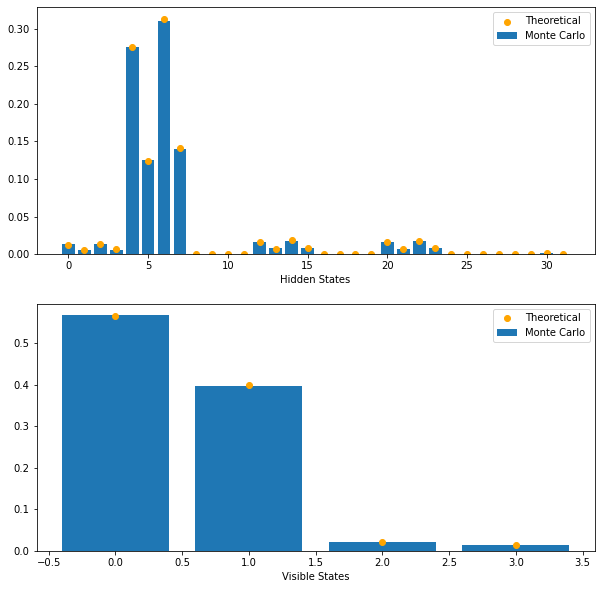

In [16]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax1.bar(np.arange(2**nHidden), probHCfgGivenVCfgMC)
ax1.scatter(np.arange(2**nHidden), probHCfgGivenVCfgTheory, color='orange')
ax1.set_xlabel('Hidden States')
ax1.legend(['Theoretical', 'Monte Carlo'])
ax2 = plt.subplot(212)
ax2.bar(np.arange(2**nVisible), probVCfgGivenHCfgMC)
ax2.scatter(np.arange(2**nVisible), probVCfgGivenHCfgTheory, color='orange')
ax2.set_xlabel('Visible States')
ax2.legend(['Theoretical', 'Monte Carlo'])

In [13]:
def VHStates2Int(v,h):
    vAsInt = States2Int(v,refVisible)
    hAsInt = States2Int(h, refHidden)
    return vAsInt * 2**nHidden + hAsInt

probVCfgAndHCfgMC = np.zeros(2**(nHidden + nVisible))
probVCfgMC = np.zeros(2**(nVisible))
probHCfgMC = np.zeros(2**(nHidden))
probVCfgAndHCfgTheory = np.zeros(2**(nHidden + nVisible))
VHEnergyAll = np.zeros((2**nVisible, 2**nHidden))

for h in range(2**nHidden):
    rbm.statesHidden = Int2States(h, nHidden)
    for v in range(2**nVisible):
        rbm.statesVisible = Int2States(v, nVisible)
        VHenergy = np.exp(-rbm.Energy())
        VHEnergyAll[v,h] = VHenergy
        probVCfgAndHCfgTheory[v * 2**nHidden + h] = VHenergy
Z = np.sum(VHEnergyAll)
probVCfgAndHCfgTheory = probVCfgAndHCfgTheory/ Z
probVCfgTheory = np.sum(VHEnergyAll, axis = 1).flatten() / Z
probHCfgTheory = np.sum(VHEnergyAll, axis=0).flatten()/Z


for i in range(100000):
    rbm.RandomizeStates()
    rbm.SampleVH()
    probVCfgAndHCfgMC[VHStates2Int(rbm.statesVisible, rbm.statesHidden)] +=1.0/100000
    probVCfgMC[States2Int(rbm.statesVisible, refVisible)] += 1.0/100000
    probHCfgMC[States2Int(rbm.statesHidden, refHidden)] += 1.0/100000

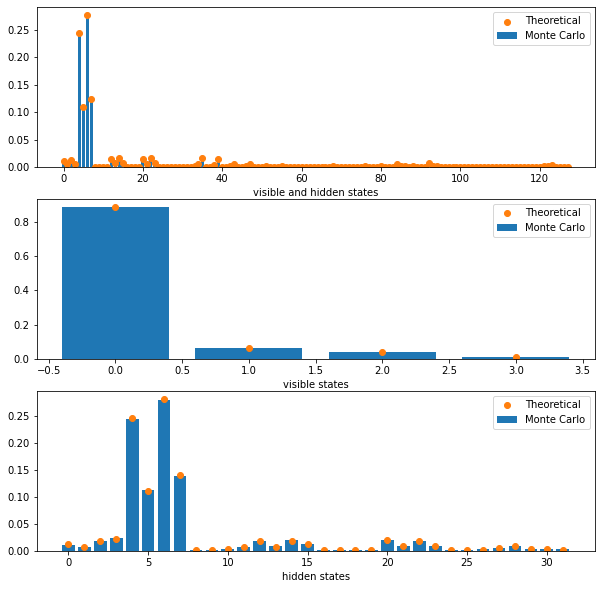

In [18]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
ax1.bar(np.arange(2**(nVisible+nHidden)), probVCfgAndHCfgMC)
ax1.scatter(np.arange(2**(nVisible+nHidden)), probVCfgAndHCfgTheory)
ax1.set_xlabel('visible and hidden states')
ax1.legend(['Theoretical', 'Monte Carlo'])
ax2 = plt.subplot(312)
ax2.bar(np.arange(2**nVisible), probVCfgMC)
ax2.scatter(np.arange(2**nVisible), probVCfgTheory)
ax2.set_xlabel('visible states')
ax2.legend(['Theoretical', 'Monte Carlo'])
ax3 = plt.subplot(313)
ax3.bar(np.arange(2**nHidden), probHCfgMC)
ax3.scatter(np.arange(2**nHidden), probHCfgTheory)
ax3.set_xlabel('hidden states')
ax3.legend(['Theoretical', 'Monte Carlo'])

Unsupervised Learning

In [14]:
nHidden = 5
nVisible = 3
refHidden = np.zeros(nHidden,dtype=int)
for i in range(nHidden):
    refHidden[i] = 2**(nHidden-1-i)
refVisible = np.zeros(nVisible,dtype=int)
for i in range(nVisible):
    refVisible[i] = 2**(nVisible-1-i)
def Data2Distribution(data):
    n = data.shape[1]
    distribution = np.zeros(2**n, dtype=np.float64)
    for i in range(data.shape[0]):
        distribution[States2Int(data[i,:], refVisible)] += 1.0/data.shape[0]
    return distribution

In [8]:
prob_dist=np.random.ranf(2**nVisible)
prob_dist=prob_dist/np.sum(prob_dist)
samples=np.random.choice(range(0,2**nVisible),p=prob_dist,size=100)
dataSet = np.zeros((100, nVisible))
for i in range(100):
    dataSet[i,:] = Int2States(samples[i], nVisible)

In [62]:
rbm = RBM(nHidden,nVisible)
dw = np.zeros_like(rbm.weights)
dBVisible = np.zeros_like(rbm.statesVisible)
dBHidden = np.zeros_like(rbm.biasHidden)
lr = 0.1
M = 64
"""dataSet = np.array([
    [1,1,1],#7
    [1,1,1],#7
    [1,1,1],#7
    [1,1,1],#7
    [1,1,1],#7
    [1,1,1],#7
    [1,1,1],#7
    [1,1,1],#7
    [-1,-1,1],#1
    [-1,-1,1],#1
    [-1,-1,1],#1
    [-1,1,1],#3
    [-1,1,1],#3
    [-1,1,1],#3
    [-1,1,1]])#3
"""
N = dataSet.shape[0]
allIndices = np.arange(N)
datasetDistribution = Data2Distribution(dataSet)
energy = []

for iter in range(100 * N):
    np.random.shuffle(allIndices)
    for miniBatch in range(M):
        randIndex = allIndices[miniBatch]
        v = dataSet[randIndex].copy().flatten()
        h = rbm.SampleHidden()
        dw -= np.outer(v,h)
        dBVisible -= v
        dBHidden -= h
        rbm.RandomizeStates()
        rbm.SampleVH(2)
        dw += np.outer(rbm.statesVisible.flatten(), rbm.statesHidden.flatten())
        dBVisible += rbm.statesVisible.flatten()
        dBHidden += rbm.statesHidden.flatten()
    dw = dw/M
    dBVisible = dBVisible/M
    dBHidden = dBHidden/M
    rbm.weights -= lr * dw
    rbm.biasHidden -= lr * (dBHidden.reshape(1,-1))
    rbm.biasVisible -= lr * (dBVisible.reshape(-1,1))
    dw = np.zeros_like(rbm.weights)
    dBVisible = np.zeros_like(rbm.statesVisible)
    dBHidden = np.zeros_like(rbm.biasHidden)

    if(iter % 20 == 0):
        energ = rbm.FreeEnergy()
        energy.append(energ)

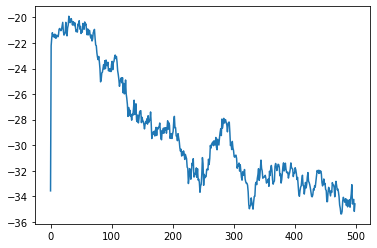

In [63]:
plt.plot(energy)

Sample from the rbm to see if the distributions match

In [23]:

#use the quoted code to sample by monte carlo if the rbm is big

probVCfgAndHCfgMC = np.zeros(2**(nHidden + nVisible))
probVCfgMC = np.zeros(2**(nVisible))
probHCfgMC = np.zeros(2**(nHidden))
probVCfgAndHCfgTheory = np.zeros(2**(nHidden + nVisible))
VHEnergyAll = np.zeros((2**nVisible, 2**nHidden))

for h in range(2**nHidden):
    rbm.statesHidden = Int2States(h, nHidden)
    for v in range(2**nVisible):
        rbm.statesVisible = Int2States(v, nVisible)
        VHenergy = np.exp(-rbm.Energy())
        VHEnergyAll[v,h] = VHenergy
        probVCfgAndHCfgTheory[v * 2**nHidden + h] = VHenergy
Z = np.sum(VHEnergyAll)
probVCfgAndHCfgTheory = probVCfgAndHCfgTheory/ Z
probVCfgTheory = np.sum(VHEnergyAll, axis = 1).flatten() / Z
probHCfgTheory = np.sum(VHEnergyAll, axis=0).flatten()/Z

"""
for i in range(100000):
    rbm.RandomizeStates()
    rbm.SampleVH()
    probVCfgAndHCfgMC[VHStates2Int(rbm.statesVisible, rbm.statesHidden)] +=1.0/100000
    probVCfgMC[States2Int(rbm.statesVisible, refVisible)] += 1.0/100000
    probHCfgMC[States2Int(rbm.statesHidden, refHidden)] += 1.0/100000
"""

'\nfor i in range(100000):\n    rbm.RandomizeStates()\n    rbm.SampleVH()\n    probVCfgAndHCfgMC[VHStates2Int(rbm.statesVisible, rbm.statesHidden)] +=1.0/100000\n    probVCfgMC[States2Int(rbm.statesVisible, refVisible)] += 1.0/100000\n    probHCfgMC[States2Int(rbm.statesHidden, refHidden)] += 1.0/100000\n'

Text(0.5, 0, 'visible states')

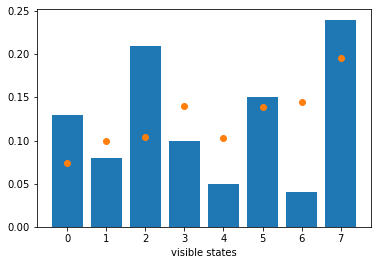

In [25]:

plt.bar(np.arange(2**nVisible), datasetDistribution)
plt.scatter(np.arange(2**nVisible), probVCfgTheory)
plt.xlabel('visible states')

MNIST

In [15]:
class RBM01:
    def __init__(self, nHidden, nVisible):
        self.nVisible = nVisible
        self.nHidden = nHidden
        self.statesVisible = np.random.choice([0.0,1], (1, nVisible))
        self.statesHidden = np.random.choice([0.0,1], (nHidden,1))
        self.weights = np.random.rand(nVisible, nHidden) * 0.02 - 0.01
        self.biasHidden = np.zeros((1, nHidden))
        self.biasVisible = np.random.rand(nVisible, 1) * 0.02 - 0.01
    def RandomizeStates(self):
        self.statesVisible = np.random.choice([0.0,1], (1, self.nVisible))
        self.statesHidden = np.random.choice([0.0,1], (self.nHidden,1))
    def FreeEnergy(self):
        energyVisible = -(self.statesVisible @ self.biasVisible).flatten()[0]
        expo = np.exp(self.biasHidden + self.weights.T@self.statesVisible.T)
        return energyVisible - np.sum(np.log(1+expo))
        
    def SampleHidden(self):
        probHGivenVCfg = self.ProbHGivenVCfg()
        result = self.statesHidden.copy().flatten()
        for j in range(self.nHidden):
            if np.random.rand() > probHGivenVCfg[j]:
                result[j] = -result[j] + 1
        return result
    def ProbHGivenVCfg(self,h=np.array([])):
        if h.size==0: h=self.statesHidden.flatten()
        m = (self.statesVisible@self.weights + self.biasHidden).flatten()
        mh = (m * h).flatten()
        probHGivenVCfg = np.exp(mh) / (np.exp(m) + 1)
        return probHGivenVCfg
    def SampleVisible(self):
        probVGivenHCfg = self.ProbVGivenHCfg()
        result = self.statesVisible.copy().flatten()
        for j in range(self.nVisible):
            if np.random.rand() > probVGivenHCfg[j]:
                result[j] = -result[j] + 1
        return result
    def ProbVGivenHCfg(self,v=np.array([])):
        if v.size==0: v=self.statesVisible.flatten()
        m = (self.weights @ self.statesHidden + self.biasVisible).flatten()
        mv = (m * v).flatten()
        probVGivenHCfg = np.exp(mv) / (np.exp(m) + 1)
        return probVGivenHCfg
    def SampleVH(self, iter=10):
        for k in range(iter):
            self.statesHidden = self.SampleHidden().reshape(-1,1)
            self.statesVisible = self.SampleVisible().reshape(1,-1)
        return self.statesVisible

In [19]:
import torch
import torch.utils.data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
batch_size = 1
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./data',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)
myData=[]
for idx, (data,target) in enumerate(train_loader):
  myData.append(np.array(data.view(-1,784)).flatten())
#print(myData[0])
print(np.shape(myData[0]))
myData=np.matrix(myData)

(784,)


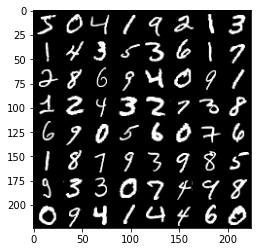

In [20]:
def PlotMe(data):
    output =  np.zeros((28 * 8, 28 * 8))
    index = 0
    for i in range(8):
        for j in range(8):
            output[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = data[index, :].reshape(28, 28)
            index += 1
    plt.imshow(output, cmap='gray')
PlotMe(myData[:64,:])

In [21]:
myData = np.round(myData)
myData = myData * 2 - 1


In [23]:
nHidden = 10
nVisible = 784
refHidden = np.zeros(nHidden,dtype=int)
refVisible = np.zeros(nVisible,dtype=int)

In [25]:
rbm = RBM01(nHidden,nVisible)
dw = np.zeros_like(rbm.weights)
dBVisible = np.zeros_like(rbm.statesVisible)
dBHidden = np.zeros_like(rbm.biasHidden)
lr = 0.1
M = 64
N = myData.shape[0]
allIndices = np.arange(N)
energy = []

for iter in range(1000):
    np.random.shuffle(allIndices)
    for miniBatch in range(M):
        randIndex = allIndices[miniBatch]
        v = myData[randIndex].copy().flatten()
        h = rbm.SampleHidden()
        dw -= np.outer(v,h)
        dBVisible -= v
        dBHidden -= h
        rbm.RandomizeStates()
        rbm.SampleVH(2)
        dw += np.outer(rbm.statesVisible.flatten(), rbm.statesHidden.flatten())
        dBVisible += rbm.statesVisible.flatten()
        dBHidden += rbm.statesHidden.flatten()
    dw = dw/M
    dBVisible = dBVisible/M
    dBHidden = dBHidden/M
    rbm.weights -= lr * dw
    rbm.biasHidden -= lr * (dBHidden.reshape(1,-1))
    rbm.biasVisible -= lr * (dBVisible.reshape(-1,1))
    dw = np.zeros_like(rbm.weights)
    dBVisible = np.zeros_like(rbm.statesVisible)
    dBHidden = np.zeros_like(rbm.biasHidden)

    if(iter % 500 == 0):
        energ = rbm.FreeEnergy()
        energy.append(energ)
        print(iter)

0
500


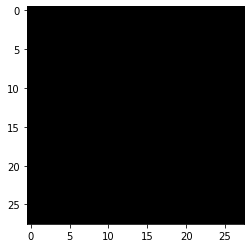

In [33]:
#rbm.statesHidden = Int2States(3, nHidden)
rbm.SampleVH(10)
out = rbm.statesVisible.flatten()
out = out.reshape(28,28)
plt.imshow(out, cmap='gray')


In [ ]:
probVCfgAndHCfgMC = np.zeros(2**(nHidden + nVisible))
probVCfgMC = np.zeros(2**(nVisible))
probHCfgMC = np.zeros(2**(nHidden))
VHEnergyAll = np.zeros((2**nVisible, 2**nHidden))
for i in range(100000):
    rbm.RandomizeStates()
    rbm.SampleVH()
    probVCfgAndHCfgMC[VHStates2Int(rbm.statesVisible, rbm.statesHidden)] +=1.0/100000
    probVCfgMC[States2Int(rbm.statesVisible, refVisible)] += 1.0/100000
    probHCfgMC[States2Int(rbm.statesHidden, refHidden)] += 1.0/100000